# Applied ML : Assignment 5

## Transfer Learning : Sentiment Analysis

## Rohit Roy | MDS202340

### Preparing the data

In [1]:
import pandas as pd
import torch
import numpy as np
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from torch import nn

In [2]:
# Load dataset
df_train = pd.read_csv("train.csv",encoding="iso-8859-1")
df_test = pd.read_csv("test.csv",encoding="iso-8859-1")

df_train = df_train[['text', 'sentiment']].dropna()
df_test = df_test[['text', 'sentiment']].dropna()

df_train['sentiment'] = df_train['sentiment'].map({'positive': 2, 'neutral': 1, 'negative': 0})
df_test['sentiment'] = df_test['sentiment'].map({'positive': 2, 'neutral': 1, 'negative': 0})

In [16]:
df_train.head()

,text,sentiment
0,id have responded if i were going,1
1,sooo sad i will miss you here in san diego,0
2,my boss is bullying me,0
3,what interview leave me alone,0
4,sons of why couldnt they put them on the rel...,0


### Pre-processing and tokenization

In [3]:
# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Remove special characters
    return text

# Apply preprocessing
df_train['text'] = df_train['text'].astype(str).apply(clean_text)
df_test['text'] = df_test['text'].astype(str).apply(clean_text)

In [4]:
# Tokenization
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Convert datasets
train_dataset = Dataset.from_pandas(df_train.rename(columns={"text": "text", "sentiment": "label"}))
test_dataset = Dataset.from_pandas(df_test.rename(columns={"text": "text", "sentiment": "label"}))

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/27480 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

### Loading the pre-trained model

In [8]:
# Load pre-trained model and modify it
class CustomDistilBERT(nn.Module):
    def __init__(self, base_model, num_labels=3):
        super(CustomDistilBERT, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(base_model.config.hidden_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_labels)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        x = self.dropout(outputs.last_hidden_state[:, 0, :])
        x = self.fc1(x)
        x = self.relu(x)
        logits = self.fc2(x)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

In [9]:
base_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
model = CustomDistilBERT(base_model.distilbert, num_labels=3)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train classifier layers
for param in model.base_model.parameters():
    param.requires_grad = False
for param in model.fc1.parameters():
    param.requires_grad = True
for param in model.fc2.parameters():
    param.requires_grad = True

# Print trainable and non-trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 98819
Non-trainable parameters: 66362880


### Fine-tuning the model

In [13]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.880800,0.835318
2,0.841000,0.797833
3,0.813800,0.784239
4,0.833500,0.779444
5,0.798300,0.777270


TrainOutput(global_step=17175, training_loss=0.8420230888799809, metrics={'train_runtime': 2308.6787, 'train_samples_per_second': 59.515, 'train_steps_per_second': 7.439, 'total_flos': 0.0, 'train_loss': 0.8420230888799809, 'epoch': 5.0})

### Classification Report

In [14]:
# Evaluate
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
print(classification_report(df_test['sentiment'], preds, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.67      0.63      0.65      1001
     neutral       0.61      0.69      0.65      1430
    positive       0.71      0.63      0.67      1103

    accuracy                           0.66      3534
   macro avg       0.66      0.65      0.66      3534
weighted avg       0.66      0.66      0.66      3534



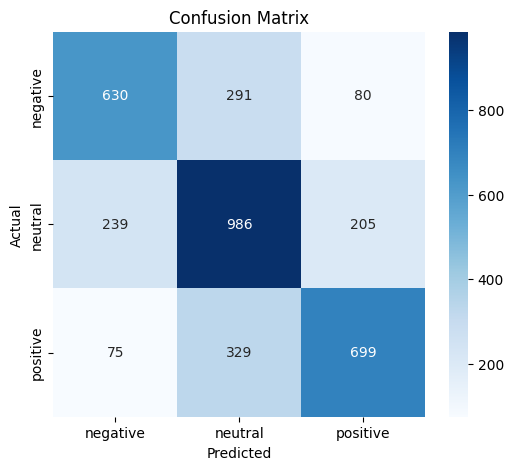

In [15]:
# Confusion Matrix
cm = confusion_matrix(df_test['sentiment'], preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()